# To simulate simplistic AGN lightcurves with some physical input parameters:

last edit: July 10th
taken from: https://github.com/astro-datalab/notebooks-latest/blob/master/05_Contrib/TimeDomain/PhotoReverberationMappingAGN/PhotoReverberationMappingAGN.ipynb

In [8]:
try:
    import photRM
except:
    !pip install speclite
    import photRM

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

##simulating variable AGNs from the 
!pip install -r requirements.txt

import numpy as np
from scipy import stats
import time
import pandas as pd
import os
import sys
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import json
import requests
import pickle


try:
    import umap
    import umap.plot

except:
    !pip install umap-learn[plot]
from astroquery.ipac.ned import Ned
from astroquery.heasarc import Heasarc
from astroquery.gaia import Gaia

from astropy.coordinates import SkyCoord, name_resolve
import astropy.units as u
from astropy.table import Table, vstack, hstack, unique
from astropy.io import fits,ascii
from astropy.time import Time
from astropy.timeseries import TimeSeries


try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

try:
    import lightkurve as lk
except ImportError:
    !pip install lightkurve --upgrade
    import lightkurve as lk
        
try:
    from acstools import acszpt
except ImportError:
    !pip install acstools
    from acstools import acszpt

import warnings
warnings.filterwarnings('ignore')

#try:
#    from unTimely_Catalog_tools import unTimelyCatalogExplorer
#except ImportError:
#    if not os.path.exists('./unTimely_Catalog_explorer'):
#        !git clone https://github.com/fkiwy/unTimely_Catalog_explorer.git
#    sys.path.append('./unTimely_Catalog_explorer')
#    from unTimely_Catalog_tools import unTimelyCatalogExplorer
    
import tempfile

## for ZTF query by name
try:
    from alerce.core import Alerce
except ImportError:
    !pip install alerce
    from alerce.core import Alerce

try:
    import umap
    import umap.plot

except:
    !pip install umap-learn[plot]

# Local code imports
sys.path.append('code/')
from fluxconversions import convert_WISEtoJanskies, convertACSmagtoflux
from panstarrs import ps1cone, ps1search, checklegal, ps1metadata, addfilter, improve_filter_format, search_lightcurve
from gaia_functions import Gaia_retrieve_EPOCH_PHOTOMETRY, Gaia_mk_lightcurves, Gaia_mk_MultiIndex
from HCV_functions import get_hscapiurl, hcvcone, hcvsearch, hcvmetadata, cat2url, checklegal_hcv
from mast_functions import resolve, mastQuery
from icecube_functions import icecube_get_catalog
from sample_selection import get_lamassa_sample, get_macleod16_sample, get_ruan_sample, get_macleod19_sample, get_sheng_sample, \
    get_green_sample, get_lyu_sample, get_lopeznavas_sample, get_hon_sample, get_yang_sample,get_SDSS_sample, get_paper_sample, clean_sample
from ztf_functions import ZTF_id2coord,ZTF_get_lightcurve

from tqdm import tqdm

# Defined metric to be used by umap. DTW is appropriate for time series distance

import numba

def unify_lc(df_lc,bands_inlc=['zr','zi','zg',],xres=160,numplots=1):
    x_ztf = np.linspace(0,1600,xres) # X array for interpolation
    x_wise = np.linspace(0,4000,int(xres*2)) # X array for interpolation

    printcounter = 0
    objects,dobjects,flabels = [],[],[]

    for obj in tqdm(df_lc.data.count(axis=0,level=0).index):

        singleobj = df_lc.data.loc[obj,:,:,:]    
        label = singleobj.index.unique('label')
        bands = singleobj.loc[obj,label[0],:,:].index.get_level_values('band')[:].unique()
        keepobj=0
        if len(np.intersect1d(bands,bands_inlc))==len(bands_inlc):
            if printcounter<numplots:
                fig= plt.subplots(figsize=(15,5))
                    
            obj_newy = [ [] for _ in range(len(bands_inlc))]
            obj_newdy = [ [] for _ in range(len(bands_inlc))]

            keepobj = 1 # 
            for l,band in enumerate(bands_inlc):
                band_lc = singleobj.loc[obj,label[0], band, :]
                band_lc_clean = band_lc[band_lc.index.get_level_values('time') < 65000]
                x,y,dy = np.array(band_lc_clean.index.get_level_values('time')-band_lc_clean.index.get_level_values('time')[0]),np.array(band_lc_clean.flux),np.array(band_lc_clean.err)

                x2,y2,dy2 = x[np.argsort(x)],y[np.argsort(x)],dy[np.argsort(x)]
                if len(x2)>5:
                    n = np.sum(x2==0)
                    for b in range(1,n): # this is a hack of shifting time of different lightcurves by a bit so I can interpolate! 
                        x2[::b+1]=x2[::b+1]+1*0.001 
                
                    f = interpolate.interp1d(x2,y2,kind='previous',fill_value="extrapolate")
                    df = interpolate.interp1d(x2,dy2,kind='previous',fill_value="extrapolate")
                    
                    if printcounter<numplots:    
                        plt.errorbar(x2,y2,dy2 , capsize = 1.0,marker='.',linestyle='', label = label[0]+band)
                        if band=='w1' or band=='w2':
                            plt.plot(x_wise,f(x_wise),'--',label='nearest interpolation '+str(band))
                        else:
                            plt.plot(x_ztf,f(x_ztf),'--',label='nearest interpolation '+str(band))
                
                    if band =='w1' or band=='w2':
                        obj_newy[l] = f(x_wise)#/f(x_wise).max()
                        obj_newdy[l] = df(x_wise)
                    else:
                        obj_newy[l] = f(x_ztf)#/f(x_ztf).max()
                        obj_newdy[l] = df(x_ztf)#/f(x_ztf).max()
                        
                if len(obj_newy[l])<5: #don't keep objects which have less than x datapoints in any keeoping bands
                    keepobj = 0         
            
            if printcounter<numplots:
                plt.title('Object '+str(obj)+' from '+label[0]+' et al.')
                plt.xlabel('Time(MJD)')
                plt.ylabel('Flux(mJy)')
                plt.legend()
                plt.show()
                printcounter+=1


        if keepobj:
            objects.append(obj_newy)
            dobjects.append(obj_newdy)
            flabels.append(label[0])
    return np.array(objects),np.array(dobjects),flabels


def combine_bands(objects,bands):
    '''
    combine all lightcurves in individual bands of an object
    into one long array, by appending the indecies.
    '''
    dat = []
    for o,ob in enumerate(objects):
        obj = []
        for b in range(len(bands)):
            obj = np.append(obj,ob[b],axis=0)
        dat.append(obj)
    return np.array(dat)

def mean_fractional_variation(lc,dlc):
    '''A common way of defining variability'''
    meanf = np.mean(lc) #mean flux of all points
    varf = np.std(lc)**2
    deltaf = np.mean(dlc)**2 
    fvar = (np.sqrt(varf-deltaf))/meanf
    return fvar

def stat_bands(objects,dobjects,bands):
    '''
    returns arrays with maximum,mean,std flux in the 5sigma clipped lightcurves of each band .
    '''
    fvar,maxarray,meanarray = np.zeros((len(bands),len(objects))),np.zeros((len(bands),len(objects))),np.zeros((len(bands),len(objects)))
    for o,ob in enumerate(objects):
        for b in range(len(bands)):
            clipped_arr,l,u = stats.sigmaclip(ob[b], low=5.0, high=5.0)
            clipped_varr,l,u = stats.sigmaclip(dobjects[o,b,:], low=5.0, high=5.0)
            maxarray[b,o] = clipped_arr.max()
            meanarray[b,o] = clipped_arr.mean()
            fvar[b,o] = mean_fractional_variation(clipped_arr,clipped_varr)
    return fvar,maxarray,meanarray


def normalize_objects(data):
    '''
    normalize objects in all bands together.
    '''
    # normalize each databand
    row_sums = data.max(axis=1)
    return data / row_sums[:, np.newaxis]

# Shuffle before feeding to umap
def shuffle_datalabel(data,labels):
    """shuffles the data, labels and also returns the indecies """
    p = np.random.permutation(len(data))
    data2 = data[p,:]
    fzr=np.array(labels)[p.astype(int)]
    return data2,fzr,p

@numba.njit()
def dtw_distance(series1, series2):
    """
    Returns the DTW similarity distance between two 2-D
    timeseries numpy arrays.
    Arguments:
        series1, series2 : array of shape [n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
    Returns:
        DTW distance between sequence 1 and 2
    """
    l1 = series1.shape[0]
    l2 = series2.shape[0]
    E = np.empty((l1, l2))

    # Fill First Cell
    E[0][0] = np.square(series1[0] - series2[0])

    # Fill First Column
    for i in range(1, l1):
        E[i][0] = E[i - 1][0] + np.square(series1[i] - series2[0])

    # Fill First Row
    for i in range(1, l2):
        E[0][i] = E[0][i - 1] + np.square(series1[0] - series2[i])

    for i in range(1, l1):
        for j in range(1, l2):
            v = np.square(series1[i] - series2[j])

            v1 = E[i - 1][j]
            v2 = E[i - 1][j - 1]
            v3 = E[i][j - 1]

            if v1 <= v2 and v1 <= v3:
                E[i][j] = v1 + v
            elif v2 <= v1 and v2 <= v3:
                E[i][j] = v2 + v
            else:
                E[i][j] = v3 + v

    return np.sqrt(E[-1][-1])
from scipy import interpolate

## MultiIndex Pandas data frame object in which we can append the light curves:
class MultiIndexDFObject:
    '''
    Pandas data frame MultiIndex object. 
    - add(): append new MultiIndex light curve data frame.
    - .data returns the data.
    '''
    def __init__(self):
        pass
    
    def append(self,x):
        try:
            self.data
        except AttributeError:
            self.data = x.copy()
        else:
            self.data = pd.concat([self.data , x])
            
    def pickle(self,x):
        self.data.to_pickle(x)  
        
    def load_pickle(self,x):
        with open(x , "rb") as f:
            self.data = pickle.load(f)
            
    def remove(self,x):
        self.data.drop(x,inplace=True)
        self.data.reset_index()

plt.style.use('bmh')

try:
    import pickle5 as pickle
except:
    !pip3 install pickle5
    import pickle5 as pickle



  Cloning https://github.com/fkiwy/unTimely_Catalog_explorer to /tmp/pip-req-build-hgtxywz9
  Running command git clone --filter=blob:none --quiet https://github.com/fkiwy/unTimely_Catalog_explorer /tmp/pip-req-build-hgtxywz9
  Resolved https://github.com/fkiwy/unTimely_Catalog_explorer to commit 954b06b5dc91c207c335e652083327c4ec136dd9
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


A composit quasar spectrum shown together with ZTF filter, and as variability might be stronger in emission lines two example redshifts where ZTF filters are strongly contaminated by nebular emission are shown:

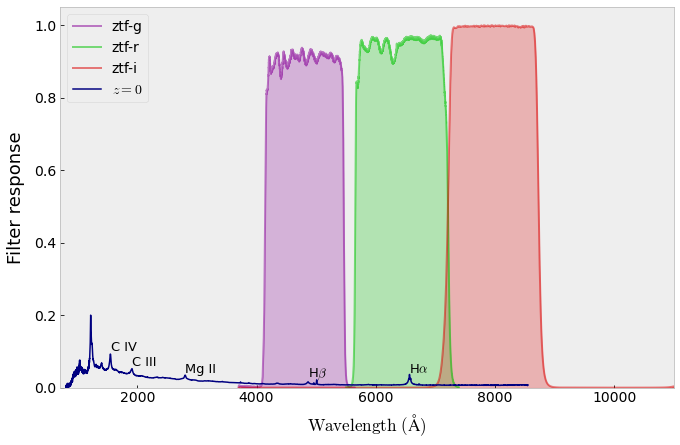

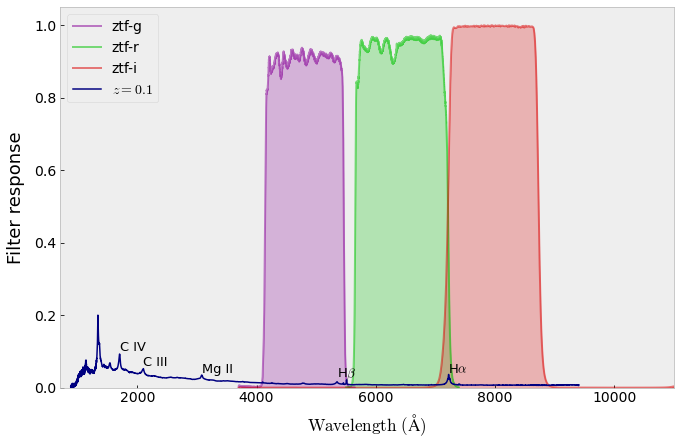

In [9]:
photRM.filters_viz(z=0, phot_sys='ZTF', save=False, comp_spec_path='data/')
photRM.filters_viz(z=0.1, phot_sys='ZTF', save=False, comp_spec_path='data/')


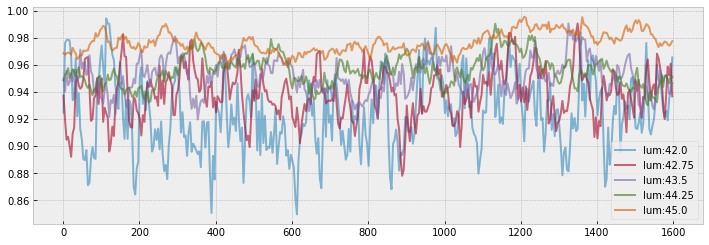

In [10]:
np.random.seed(0)


plt.figure(figsize=(12,4))

# Generate light curves in two different bands
for l in np.linspace(42,45,5):
    x_band, y_band, line_response =photRM.lc_two_bands(1600,osc=True,A=0.14,noise=0.00005,z=0.05,lag='random',lum=l,wl=0.2,wc=0.8,plot_kernel=False)
    #plt.errorbar(y_band['t'][::4],y_band['flux'][::4],yerr=y_band['err'][::4],markersize=2,alpha=0.6,capsize=3,label='continuum + line LC (Y-band)')
    plt.plot(y_band['t'][::4],y_band['flux'][::4],markersize=2,alpha=0.6,label='lum:'+str(l))
plt.legend()


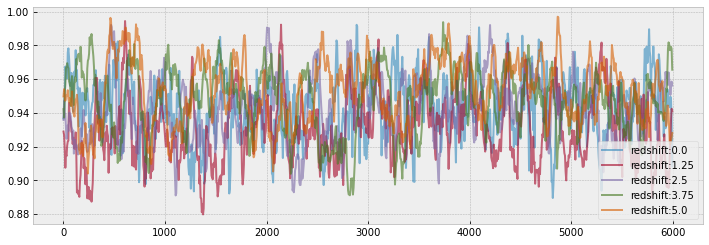

In [11]:
plt.figure(figsize=(12,4))
for zz in np.linspace(0,5,5):
    x_band, y_band, line_response =photRM.lc_two_bands(6000,osc=True,A=0.14,noise=0.00005,z=zz,lum=43,wl=0.2,wc=0.8,plot_kernel=False)
    #plt.errorbar(y_band['t'][::4],y_band['flux'][::4],yerr=y_band['err'][::4],markersize=2,alpha=0.6,capsize=3,label='continuum + line LC (Y-band)')
    plt.plot(y_band['t'][::6],y_band['flux'][::6],markersize=2,alpha=0.6,label='redshift:'+str(zz))
plt.legend()

In [12]:
np.shape(y_band.info(()))
print(len(y_band))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       6000 non-null   int64  
 1   flux    6000 non-null   float64
 2   err     6000 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 140.8 KB
6000


In [13]:
def unify_lc2(zstep=10,lumstep=10,xres=160,numplots=1):
    x_ztf = np.linspace(0,1600,xres) # X array for interpolation
    printcounter = 0
    objects,dobjects,flabels = [],[],[]
    redshifts=np.linspace(0,0.1,zstep)
    luminosities = np.linspace(41,46,lumstep)
    for z in redshifts:
        for luminosity in luminosities:
            label = 'theory'
            x_band, y_band, line_response =photRM.lc_two_bands(1600,osc=True,A=0.14,noise=0.00005,z=z,lag='random',lum=luminosity,wl=0.2,wc=0.8,plot_kernel=False)

            if printcounter<numplots:
                fig= plt.subplots(figsize=(15,5))
                    
            x,y,dy = np.array(y_band['t']),np.array(y_band['flux']),np.array(y_band['err'])
            f = interpolate.interp1d(x,y,kind='previous',fill_value="extrapolate")
            df = interpolate.interp1d(x,dy,kind='previous',fill_value="extrapolate")
                                     
            obj_newy = f(x_ztf)#/f(x_ztf).max()
            obj_newdy = df(x_ztf)#/f(x_ztf).max()
                              
            if printcounter<numplots:
                plt.errorbar(x,y,dy , capsize = 1.0,marker='.',linestyle='', label = 'z='+str(z)+' , lum='+str(luminosity))
                plt.plot(x_ztf,f(x_ztf),'--',label='nearest interpolation')
                plt.xlabel('Time(MJD)')
                plt.ylabel('Flux(mJy)')
                plt.legend()
                plt.show()
                printcounter+=1

            objects.append(obj_newy)
            dobjects.append(obj_newdy)
            flabels.append(label)
    return np.array(objects),np.array(dobjects),flabels

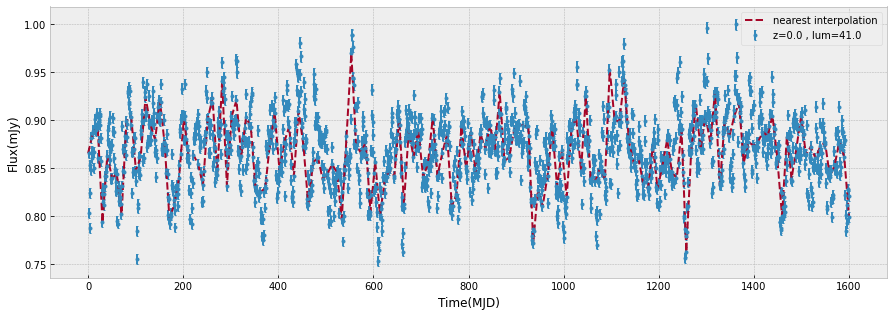

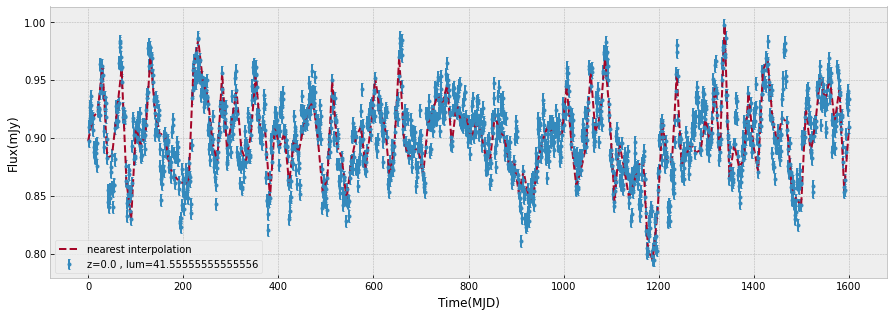

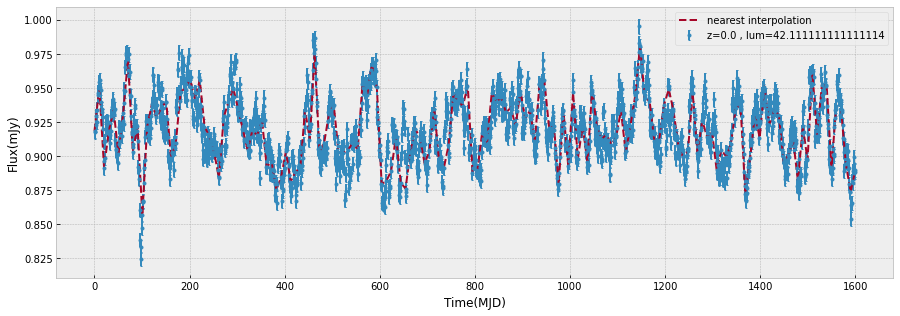

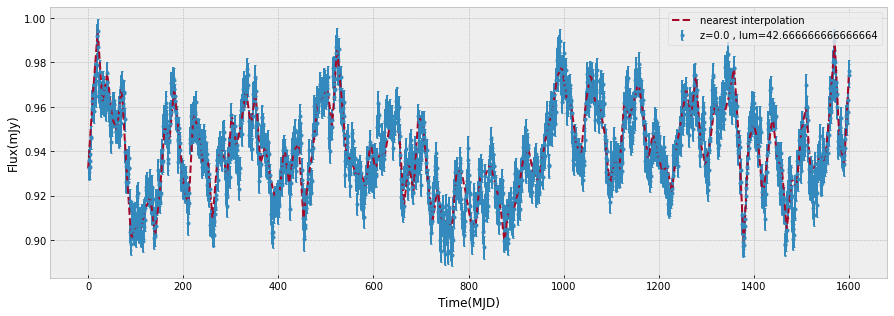

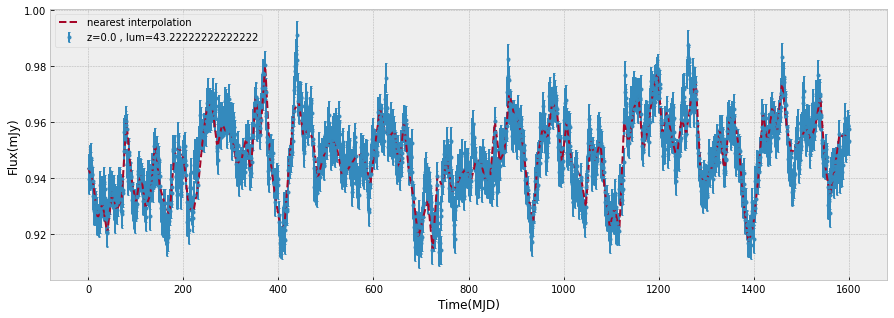

In [14]:
objects,dobjects,flabels = unify_lc2(numplots=5)

In [15]:
bands_inlc = ['zr']#,'panstarrs g','panstarrs r','panstarrs i','panstarrs z', 'panstarrs y']

dat = combine_bands(objects,bands_inlc)
fvar, maxarray,meanarray = stat_bands(objects,dobjects,bands_inlc)
dat = normalize_objects(dat)
data,fzr,p = shuffle_datalabel(dat,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]   

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)